<a href="https://colab.research.google.com/github/aborundiya/RNN/blob/master/RNN_Basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from io import open
import os, time, string, random, math 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from IPython.display import clear_output

In [3]:
language = []
data = []
x = []
y = [] 

with open("name2lang.txt",'r') as f : 
  for line in f : 
    line = line.split(',')
    name = line[0].strip()
    lang = line[1].strip()
    if not lang in language:
      language.append(lang)
    x.append(name)
    y.append(lang)
    data.append((name,lang))

n_language = len(language)

In [4]:
print(language)

['Portuguese', 'Irish', 'Spanish', 'Vietnamese', 'Chinese', 'Greek', 'Czech', 'Dutch', 'Japanese', 'French', 'German', 'Scottish', 'English', 'Russian', 'Polish', 'Arabic', 'Korean', 'Italian']


In [5]:
print(data[0:5])

[('Abreu', 'Portuguese'), ('Albuquerque', 'Portuguese'), ('Almeida', 'Portuguese'), ('Alves', 'Portuguese'), ('Araujo', 'Portuguese')]


In [6]:
X_train, X_val,Y_train, Y_val = train_test_split(x,y,test_size = 0.2,random_state=0,stratify=y)

In [7]:
print(len(X_train), len(X_val))

16040 4010


#Encoding Names and Languages

In [8]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [9]:
print(n_letters)

57


In [10]:
def name_rep(name):
  rep = torch.zeros(len(name),1,n_letters)
  for index, letter in enumerate(name):
    pos = all_letters.find(letter)
    rep[index][0][pos]=1
  return rep

In [11]:
def lang_rep(lang):
  return torch.tensor([language.index(lang)],dtype=torch.long)

In [12]:
name_rep("Abreu")

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

In [13]:
lang_rep("Irish")

tensor([1])

#Basic Visualization

In [14]:
count = {}
for l in language:
  count[l] = 0
for d in data:
  count[d[1]] +=1 

In [15]:
print(count)

{'Portuguese': 74, 'Irish': 232, 'Spanish': 298, 'Vietnamese': 73, 'Chinese': 268, 'Greek': 203, 'Czech': 519, 'Dutch': 297, 'Japanese': 991, 'French': 277, 'German': 724, 'Scottish': 100, 'English': 3668, 'Russian': 9384, 'Polish': 139, 'Arabic': 2000, 'Korean': 94, 'Italian': 709}


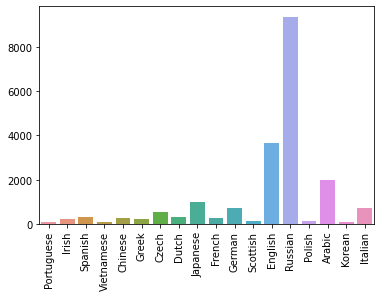

In [16]:
plt_= sns.barplot(list(count.keys()),list(count.values()))
plt_.set_xticklabels(plt_.get_xticklabels(),rotation = 90)
plt.show()

In [17]:
class RNN_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_net, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)


In [69]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN,self).__init__()
    self.hidden = hidden_size
    self.rnn_cell = nn.RNN(input_size,hidden_size)
    self.h2o = nn.Linear(hidden_size,output_size)
    self.softmax = nn.LogSoftmax(dim=1)
  
  def forward(self,input_, hidden = None , batch_size =1 ):
    out , hidden = self.rnn_cell(input_,hidden)
    output = self.h2o(hidden.view(-1,self.hidden_size))
    output = self.softmax(output)
    return output , hidden 
  
  def init_hidden(self, batch_size =1 ):
    return torch.zeros(1, batch_size, self.hidden_size)


In [73]:
n_hidden = 128
rnn = RNN_net(n_letters,n_hidden,n_language)


In [74]:
def infer(net, name ):
  net.eval()
  name_ohe = name_rep(name)
  hidden = rnn.init_hidden()
  for i in range(name_ohe.size()[0]):
    output , hidden = rnn(name_ohe[i], hidden)
  return output 

In [75]:
output = infer(rnn,"Adam")
index = torch.argmax(output)
print(output,index)

tensor([[-2.8926, -2.8698, -2.9573, -2.8416, -2.9306, -2.8342, -2.8351, -2.8702,
         -2.9470, -2.8971, -2.8670, -2.8588, -2.8974, -2.9702, -2.9518, -2.8671,
         -2.8394, -2.9165]], grad_fn=<LogSoftmaxBackward>) tensor(5)


#Evaluate 

In [76]:
def dataloader(npoints, x_, y_):
  ret_data = []
  for i in range(npoints):
    index_ = np.random.randint(len(x_))
    name , lang = x_[index_] , y_[index_]
    ret_data.append((name,lang,name_rep(name),lang_rep(lang)))
  return ret_data


In [77]:
dataloader(2, X_train, Y_train)


[('Jakutkin',
  'Russian',
  tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0.]],
  
          [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 1., 0., 0., 0., 0., 0., 0.

In [78]:
def eval(net, npoints, k , X_, Y_):
  
  data = dataloader(npoints, X_, Y_)
  correct = 0 

  for name , language , name_ohe, lang_rep in data : 
    output = infer(net,name)

    val, indices = output.topk(k)
    #print("Indice" ,indices)
    #print("Lang_rep",lang_rep)
    if lang_rep in indices : 
      correct +=1

  accuracy = correct / npoints 
  return accuracy 

In [79]:
eval(rnn, 1000,3,X_val, Y_val)

0.143

In [80]:
def train ( net, opt, criteria, npoints): 

  opt.zero_grad()
  total_loss = 0.0 
  data = dataloader(npoints,X_train, Y_train)

  for name, language, name_ohe, lang_rep in data : 

    hidden = net.init_hidden()

    for i in range(name_ohe.size()[0]):
      output , hidden = net(name_ohe[i], hidden)
    
    loss = criteria(output, lang_rep)
    loss.backward(retain_graph = True)

    total_loss += loss
  
  opt.step()

  return total_loss / npoints 

In [81]:
criteria = nn.NLLLoss()
opt = optim.SGD(rnn.parameters(),lr= 0.01, momentum=0.9)

In [82]:
%%time
train(rnn,opt,criteria,200)

CPU times: user 270 ms, sys: 5.26 ms, total: 275 ms
Wall time: 283 ms


tensor(2.8947, grad_fn=<DivBackward0>)

In [83]:
eval(rnn,1000,1,X_val,Y_val)

0.453

In [84]:
def train_setup(net, lr = 0.01 , momentum = 0.9, n_batches = 100, batch_size = 10, display_freq =5 ): 
  criteria = nn.NLLLoss()
  opt = optim.SGD(net.parameters(), lr = lr , momentum = momentum)
  loss_arr = np.zeros(n_batches + 1 )

  for i in range(n_batches):
    loss_arr[i + 1 ] = (loss_arr[i] * i + train(net,opt,criteria,npoints=batch_size)) / (i + 1)
    if i % display_freq == display_freq - 1 : 
      clear_output(wait = True ) 

      print("Iteration " , i , "Top 1 : " , eval(net,batch_size,1,X_val, Y_val) , "Top 2 : ", eval(net, batch_size, 2, X_val, Y_val))
      plt.figure
      plt.plot(loss_arr[1:i],'-*')
      plt.xlabel("Iterations")
      plt.ylabel("Loss")
      plt.show()
      print('\n\n')

Iteration  99 Top 1 :  0.49609375 Top 2 :  0.65625


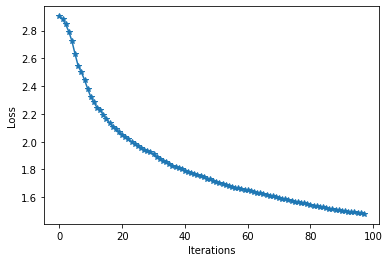

In [85]:
n_hidden = 128 
net = RNN_net(n_letters,n_hidden,n_language)
train_setup(net, lr=0.0005, n_batches=100, batch_size=256)